In [1]:
# Add description here
#
# *Note:* You can open this file as a notebook (JupyterLab: right-click on it in the side bar -> Open With -> Notebook)

In [2]:
# Uncomment the next two lines to enable auto reloading for imported modules
# %load_ext autoreload
# %autoreload 2
# For more info, see:
# https://docs.ploomber.io/en/latest/user-guide/faq_index.html#auto-reloading-code-in-jupyter

In [3]:
# If this task has dependencies, list them them here
# (e.g. upstream = ['some_task']), otherwise leave as None.
upstream = ['preprocessing']

# This is a placeholder, leave it as None
product = None

In [4]:
# Parameters
upstream = {
    "preprocessing": {
        "nb": "C:\\Users\\kaitr\\Documents\\GitHub\\spaceship-titanic\\products\\preprocessing.ipynb",
        "encoder": "C:\\Users\\kaitr\\Documents\\GitHub\\spaceship-titanic\\products\\encoder.pkl",
        "train": "C:\\Users\\kaitr\\Documents\\GitHub\\spaceship-titanic\\products\\train.csv",
        "val": "C:\\Users\\kaitr\\Documents\\GitHub\\spaceship-titanic\\products\\val.csv",
        "test": "C:\\Users\\kaitr\\Documents\\GitHub\\spaceship-titanic\\products\\test.csv",
    }
}
product = {
    "nb": "C:\\Users\\kaitr\\Documents\\GitHub\\spaceship-titanic\\products\\decision_tree_model.ipynb",
    "model": "C:\\Users\\kaitr\\Documents\\GitHub\\spaceship-titanic\\products\\decision_tree\\model.pkl",
    "confusion": "C:\\Users\\kaitr\\Documents\\GitHub\\spaceship-titanic\\products\\decision_tree\\confusion.png",
    "confusion_test": "C:\\Users\\kaitr\\Documents\\GitHub\\spaceship-titanic\\products\\decision_tree\\confusion_test.png",
    "pr_curve": "C:\\Users\\kaitr\\Documents\\GitHub\\spaceship-titanic\\products\\decision_tree\\pr_curve.png",
}


C:\Users\kaitr\Anaconda3\envs\spaceship_titanic\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


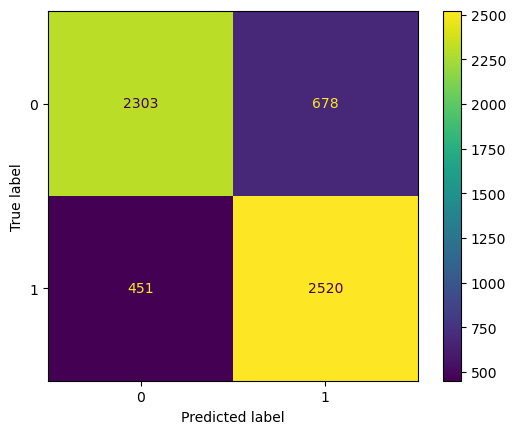

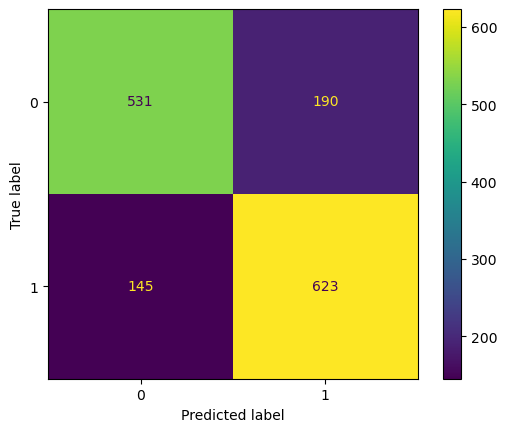

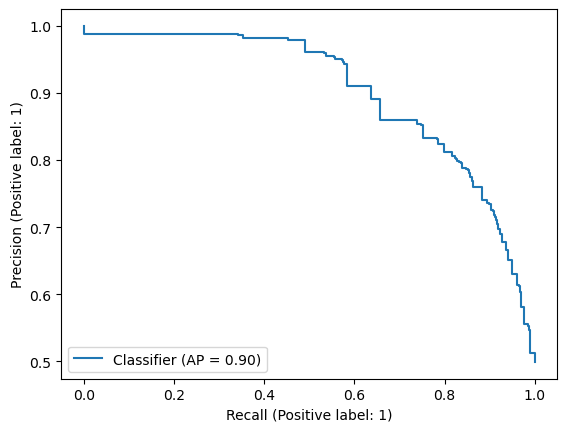

Train F1: 0.8169881666396499
Val F1: 0.7881087919038582


In [5]:
import pickle as pkl

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve, f1_score, PrecisionRecallDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

train = pd.read_csv(upstream['preprocessing']['train'])
val = pd.read_csv(upstream['preprocessing']['val'])

train.set_index('PassengerId', inplace = True)
val.set_index('PassengerId', inplace = True)

train_X = train.drop('Transported', axis = 1)
train_y = train['Transported']

val_X = val.drop('Transported', axis = 1)
val_y = val['Transported']

model = DecisionTreeClassifier(max_depth = 5, class_weight = 'balanced')
pipe = Pipeline([('scaler', StandardScaler()),
                 ('model', CalibratedClassifierCV(model, method = 'isotonic', cv = 3))])

pipe.fit(train_X, train_y)

with open(product['model'], 'wb') as f:

    pkl.dump(pipe, f)

probs = pipe.predict_proba(train_X)
probs = probs[:, 1]

probs_val = pipe.predict_proba(val_X)
probs_val = probs_val[:, 1]

precision, recall, thresholds = precision_recall_curve(train_y, probas_pred = probs)

thresholds_df = pd.DataFrame({'precision' : precision[:-1],
                              'recall' : recall[:-1],
                              'threshold' : thresholds})

thresholds_df['f1'] = (2 * thresholds_df['precision'] * thresholds_df['recall']) / (thresholds_df['precision'] + thresholds_df['recall'])
threshold = thresholds_df[thresholds_df['f1'] == max(thresholds_df['f1'])]['threshold'].values[0]

preds = [1 if prob > threshold else 0 for prob in probs]
preds_val = [1 if prob > threshold else 0 for prob in probs_val]

disp = ConfusionMatrixDisplay.from_predictions(train_y, preds)
plt.savefig(product['confusion'])
plt.show()

disp = ConfusionMatrixDisplay.from_predictions(val_y, preds_val)
plt.savefig(product['confusion_test'])
plt.show()

disp = PrecisionRecallDisplay.from_predictions(train_y, probs)
plt.savefig(product['pr_curve'])
plt.show()

f1 = f1_score(train_y, preds)
f1_val = f1_score(val_y, preds_val)

print(f'Train F1: {f1}')
print(f'Val F1: {f1_val}')